<a href="https://colab.research.google.com/github/Hlogy/Deep-Learning-Image-Classification/blob/main/MobileNetV2_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install ipython-autotime
%load_ext autotime

In [ ]:
import zipfile
import os
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np # linear algebra
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image,  ImageTk
from sklearn.model_selection import train_test_split
from pathlib import Path

In [ ]:
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/trashnet.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [ ]:
zip_ref = zipfile.ZipFile('/tmp/trashnet-data/dataset-resized.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp/trashdata') #Extracts the files into the /tmp folder
zip_ref.close()

In [ ]:
#Delete Trash class (downsampling since class has only around 100 images)
%rm -rf /tmp/trashdata/dataset-resized/trash

In [ ]:
len(os.listdir('/tmp/trashdata/dataset-resized')) #this makes it easier to use keras using flow from dataframe

6

time: 6.23 ms (started: 2022-01-10 17:38:50 +00:00)


In [ ]:
#Show one image of dataset:
#Getting sample image of glass class:

img_array = np.array(Image.open('/tmp/trashdata/dataset-resized/glass/glass50.jpg'))
plt.imshow(img_array)
width = Image.open('/tmp/trashdata/dataset-resized/glass/glass50.jpg').width
height = Image.open('/tmp/trashdata/dataset-resized/glass/glass50.jpg').height
print(width, height)

**Creating File Dataframe**

In [ ]:
im_dir = Path('/tmp/trashdata/dataset-resized')

In [ ]:
filepaths = list(im_dir.glob(r'**/*.jpg'))

In [ ]:
#Get a file's path sample:

filepaths[1580]

**Getting Labels from Images (my initial way of doing that)**

In [ ]:
'''def getLabel(filepath):
  label = []
  for files in filepath:
    pathstr = os.path.split(files)
    label.append(pathstr[0][31:])
  return label'''

'def getLabel(filepath):\n  label = []\n  for files in filepath:\n    pathstr = os.path.split(files)\n    label.append(pathstr[0][31:])\n  return label'

time: 4.82 ms (started: 2021-12-02 21:51:20 +00:00)


In [ ]:
'''labels = getLabel(filepaths)'''

**Mapping labels to paths (shorter):**

In [ ]:
  labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
  #os.path.split(os.path.split(filepaths[0])[0])[1]
  print (labels)

['cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard'

In [ ]:
#To save labels in current working directory if needed.
#np.savetxt("labels.txt", np.array(labels), fmt="%s")

In [ ]:
'''
#To compare between two ways of getting labels just to make sure it is correct:
compLabels = [i for i, j in zip(labels, labelss) if i == j]
print(len(labels))
print(len(labelss))
print(len(compLabels))
'''

In [ ]:
#Creating a Dataframe for both filepaths and labels:
filepaths = pd.Series(filepaths, name='Filepath').astype(str) #Turned to String
labels = pd.Series(labels, name='Labels')
print(labels)

In [ ]:
images = pd.concat([filepaths, labels], axis=1)
images

In [ ]:
image_df = images.sample(frac=1).reset_index(drop=True)

In [ ]:
#To explicitly sample 400 image from each category:

category_samples = []
for category in images['Labels'].unique():  #Get for each unique label (class) in images dataframe:
  category_slice =  images.query('Labels == @category') #the @ means target the environment variables since category here changes for each class
  #category_slice.sample(400, random_state = 1) #get 400 images of the sliced images (random so that every time it's random images)
  category_samples.append(category_slice.sample(400, random_state = 1))#save in list
#joining the different dataframes in category_samples in one df on top of each other. Then use sample again with 100% (fraction = 1)
#to shuffle the sample. random_state = 1 to reproduce result. Then reset index because they were also shuffled.
#Drop = True to prevent new indices from becoming new column
image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state = 1).reset_index(drop=True)


time: 37.2 ms (started: 2021-11-23 18:29:07 +00:00)


In [ ]:
image_df

# **TRAIN-TEST SPLIT**

In [ ]:
#Split images in image_df to train and test using functoin below from sklearn, with the following properties:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

# **Creating Generators To Not Runout of Memory**

In [ ]:
#Generators are a way of loading in the images one batch at a time so that we do not run out of memory
#ex: set the batch size for 32, load 32 images, train on them, then recycle the memory for the next batch so we don't runout
#here we can specify any image preprocssing we want to apply to images and any data augmentation
#The moblienetv2 will be used now, later mobilenetv3 and others:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    #Specifying preprocessing function. Will come form keras mobilenetv2 processing function
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split = 0.2,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range=0.2,
    shear_range = 0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    #Specifying preprocessing function. Will come form keras mobilenetv2 processing function
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input,
)

In [ ]:
#Now, using generators to specify how to load data during training

train_img = train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'Filepath',
    y_col = 'Labels',
    target_size = (224,224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = True,
    seed = 42,
    subset = 'training'
)
val_img = train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'Filepath',
    y_col = 'Labels',
    target_size = (224,224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = True,
    seed = 42,
    subset = 'validation'
)
test_img = test_generator.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'Filepath',
    y_col = 'Labels',
    target_size = (224,224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = False
)

Found 1339 validated image filenames belonging to 5 classes.
Found 334 validated image filenames belonging to 5 classes.
Found 717 validated image filenames belonging to 5 classes.


# **Modeling**

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape = (224,224,3),
    include_top = False,
    weights='imagenet',
    #pooling='avg'
)
#pretrained_model.trainable = False


9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras import layers

In [ ]:
inputs = pretrained_model.input

#x = tf.keras.layers.Dense(128,activation='relu')(pretrained_model.output)
#x = tf.keras.layers.Dense(128,activation='relu')(x)
#x = tf.keras.layers.Dense(128,activation='relu')(x)

x = tf.keras.layers.Dense(128,activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128,activation='relu')(x)
x = tf.keras.layers.GlobalAvgPool2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)

outputs = tf.keras.layers.Dense(5,activation='softmax')(x)

model = tf.keras.Model(inputs,outputs)

for layer in model.layers:
  if not isinstance(layer, layers.BatchNormalization):
      layer.trainable = True

#for layer in model.layers:
#  if layer == "BatchNormalization":
#    layer.trainable = False
#  else:
#    layer.trainable = True
print(model.summary())

In [ ]:
#Optimizer with different learning rate
'''lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)
opti = keras.optimizers.Adam(learning_rate=lr_schedule)'''

opt = keras.optimizers.Nadam(learning_rate=0.001)

In [ ]:
model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
history = model.fit(
    train_img,
    validation_data=val_img,
    epochs = 50,
    callbacks=[
             #tf.keras.callbacks.EarlyStopping(
               #   monitor = 'val_loss',
               #   patience=10,
               #   restore_best_weights=True
               #),
              ReduceLROnPlateau(monitor='val_loss', 
                    mode='min', 
                    patience= 5, 
                    factor= 0.5, 
                    min_lr= 1e-7, 
                    verbose=1)
    ]
    
)

Epoch 1/50
42/42 [==============================] - 62s 849ms/step - loss: 1.0825 - accuracy: 0.5907 - val_loss: 4.5181 - val_accuracy: 0.2575 - lr: 0.0010
Epoch 2/50
42/42 [==============================] - 33s 774ms/step - loss: 0.7333 - accuracy: 0.7446 - val_loss: 4.2974 - val_accuracy: 0.3683 - lr: 0.0010
Epoch 3/50
42/42 [==============================] - 33s 777ms/step - loss: 0.6466 - accuracy: 0.7767 - val_loss: 2.8110 - val_accuracy: 0.5030 - lr: 0.0010
Epoch 4/50
42/42 [==============================] - 33s 772ms/step - loss: 0.5371 - accuracy: 0.8200 - val_loss: 9.1673 - val_accuracy: 0.2036 - lr: 0.0010
Epoch 5/50
42/42 [==============================] - 33s 776ms/step - loss: 0.4976 - accuracy: 0.8275 - val_loss: 13.4934 - val_accuracy: 0.1737 - lr: 0.0010
Epoch 6/50
42/42 [==============================] - 33s 770ms/step - loss: 0.4468 - accuracy: 0.8633 - val_loss: 7.3111 - val_accuracy: 0.2575 - lr: 0.0010
Epoch 7/50
42/42 [==============================] - 33s 775ms/s

In [ ]:
results = model.evaluate(test_img,verbose=0)
print('Test Accuracy: {:.2f}%'.format(results[1]*100))

Test Accuracy: 91.91%


In [ ]:
predictions = np.argmax(model.predict(test_img),axis=1)
cm = confusion_matrix(test_img.labels,predictions)
clr = classification_report(test_img.labels,predictions, target_names=test_img.class_indices)

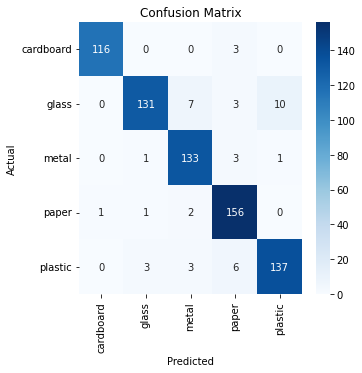

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='g',vmin=0,cmap='Blues',cbar=True)
plt.xticks(ticks=np.arange(5)+0.5, labels=test_img.class_indices, rotation=90)
plt.yticks(ticks=np.arange(5)+0.5, labels=test_img.class_indices, rotation=0)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print("Classification Report:\n--------------------------------------------------------\n", clr)

Classification Report:
--------------------------------------------------------
               precision    recall  f1-score   support

   cardboard       0.99      0.97      0.98       119
       glass       0.96      0.87      0.91       151
       metal       0.92      0.96      0.94       138
       paper       0.91      0.97      0.94       160
     plastic       0.93      0.92      0.92       149

    accuracy                           0.94       717
   macro avg       0.94      0.94      0.94       717
weighted avg       0.94      0.94      0.94       717



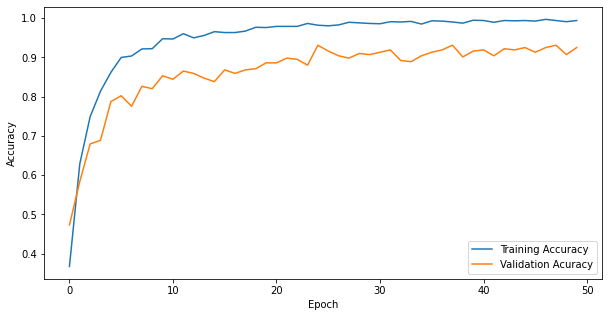

In [ ]:
plt.figure(figsize=[10,5])
plt.plot(history.history["accuracy"], label = "Training Accuracy")
plt.plot(history.history["val_accuracy"], label = "Validation Acuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label = "Training loss")
plt.plot(history.history['val_loss'], label = "Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# **Display Classified Images:**

In [ ]:
#Find a way

array([[124,   1,   0,  16,   0],
       [  0,  98,  10,   3,   8],
       [  0,   4, 111,   4,   2],
       [  1,   0,   2, 105,   1],
       [  0,  11,  10,   3,  86]])

time: 6.1 ms (started: 2021-11-02 20:32:57 +00:00)


In [ ]:
%matplotlib inline

def plotImages(images_arr):
  fig, axes = plt.subplots(1,20,figsize = (100,100))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
    ax.axis('off')
  #plt.tight_layout()
  plt.show

time: 6.92 ms (started: 2021-11-02 19:47:04 +00:00)


# **------------------------------------------------------------**

In [ ]:
#To test model on new image from url
import requests
import io
#img_path = "https://www.boxed-up.co.uk/image/cache/data/international-post-box-350x350.png"
#im = Image.open(requests.get(img_path, stream=True).raw)
#'https://cdn-japantimes.com/wp-content/uploads/2019/06/b-plastic-a-20190613.jpg'

#in case the above code didn't work, use this:
r = requests.get('https://cdn-japantimes.com/wp-content/uploads/2019/06/b-plastic-a-20190613.jpg', stream=True)
aux_im = Image.open(io.BytesIO(r.content))
aux_im
#"https://www.packari.com/out/pictures/master/product/1/902102_s00020_3.jpg"

In [ ]:
#preprocessing the image to fit the requirements of model
from io import BytesIO #The .convert('RBG) is only added if image being tested is more than 3 channels
pilImage = Image.open(BytesIO(requests.get('https://cdn-japantimes.com/wp-content/uploads/2019/06/b-plastic-a-20190613.jpg').content))#.convert('RGB')
resized_im = pilImage.resize((224, 224))

resized_im

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions


img_array = np.array(resized_im)


img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_batch)

print(img_batch.shape)

(1, 224, 224, 3)


In [ ]:
pred = model.predict(img_preprocessed)

In [ ]:
#print(pred)
classes = np.argmax(pred, axis = 1)
print(classes)

[3]


In [ ]:
#translate prediction value into name of waste category:
categories = {
    0: 'Cardboard',
    1: 'Glass',
    2: 'Metal',
    3: 'Paper',
    4: 'Plastic'
}

for i in categories:
  if i == classes[0]:
    print(categories[i])


Paper


# **Convert Model to tflite**

In [ ]:
'''# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)'''

# **Data Augmentation Example**





In [ ]:
#Function to plot images in grid to demonstrate the augmentation example
%matplotlib inline

def plotImages(images_arr):
  fig, axes = plt.subplots(1,10,figsize = (30,30))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show

In [ ]:
gen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range = 40,
        width_shift_range = 0.2,
        height_shift_range=0.2,
        shear_range = 0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
)

In [ ]:
import random
chosen_img = random.choice(os.listdir('/content/drive/MyDrive/dataset-resized/glass'))
img_path = '/content/drive/MyDrive/dataset-resized/glass/' + chosen_img
assert os.path.isfile(img_path)
im = np.expand_dims(plt.imread(img_path),0)
plt.imshow(im[0])

In [ ]:
aug_iter = gen.flow(im)

In [ ]:
aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]

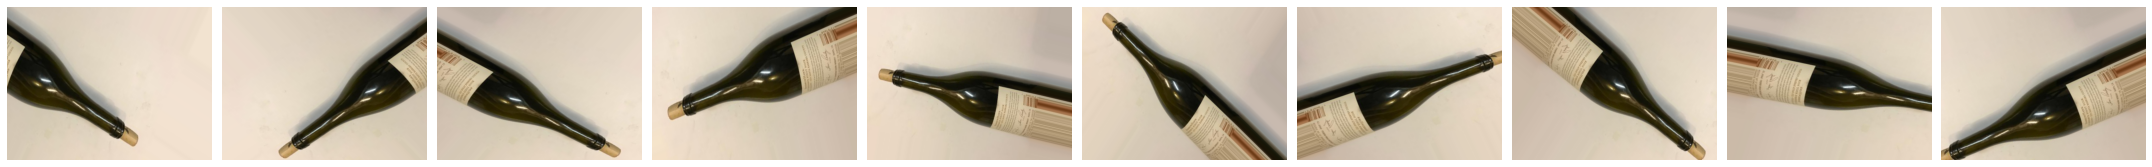

In [ ]:
plotImages(aug_images)